# Задача 1

В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (min_leaf), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции build_tree и проверьте ее работоспособность с помощью визуализации дерева (функция print_tree()).

In [654]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [655]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5)

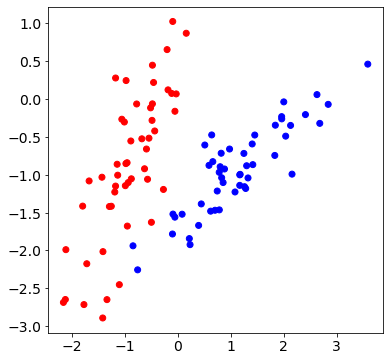

In [656]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [657]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [658]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels): #в лист подаются данные и критерий, по которому будет формироваться лист
        self.data = data
        self.labels = labels #метки классов
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов, для каждого листа формируется свой словарь "класс: количество объектов"
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels: 
            if label not in classes: #если класса нет, то записываем его
                classes[label] = 0 
            classes[label] += 1 #если есть добавлем
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [659]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}  # сформируем словарь "класс: количество объектов"
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes: # по ключу словаря считаем долю объектов
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [660]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [661]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [662]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf): #на вход функции передаются признаки, метки и критерий останова
    
    #  обозначим минимальное количество объектов в узле
    #min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [663]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf):

    quality, t, index = find_best_split(data, labels, min_leaf)
    print(quality, t, index)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf)
    false_branch = build_tree(false_data, false_labels, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    #print (quality)
    return Node(index, t, true_branch, false_branch)

In [664]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [665]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [666]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [667]:
%%time
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 5)

0.375 0.16261402870113306 0
0.07291666666666671 -1.5208896621663803 1
0.3472222222222221 -0.9478301462477035 0
0 None None
0 None None
0 None None
0 None None
Wall time: 13.4 ms


In [668]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [669]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + ' УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")
    
print_tree(my_tree)

 УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
    УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
       УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 6
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


In [670]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [671]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [672]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [673]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [674]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

Text(0.5, 1.0, 'Test accuracy=100.000')

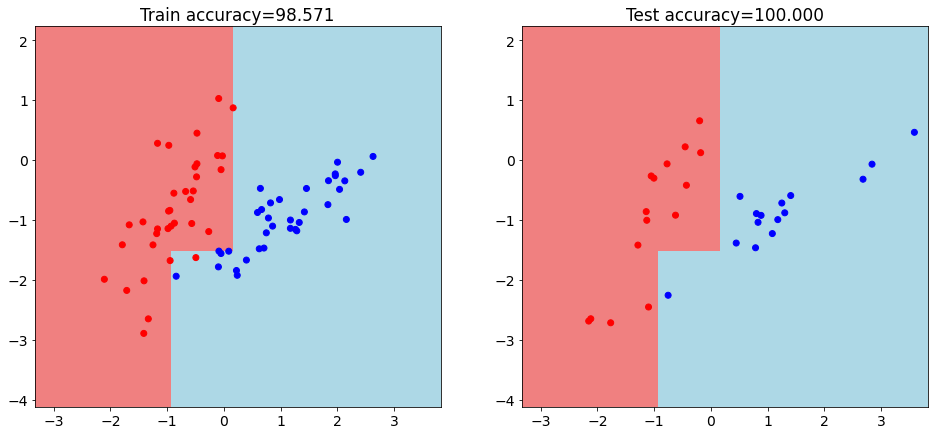

In [675]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, shading= 'nearest',cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.3f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, shading= 'nearest',cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.3f}')

# Задача 2

(*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

In [690]:
# Расчет критерия Шеннона

def shennon(labels):
    #  подсчет количества объектов разных классов
    classes = {}  # сформируем словарь "класс: количество объектов"
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    #impurity = 0
    for label in classes: # по ключу словаря считаем долю объектов
        p = classes[label] / len(labels)
        impurity = - p*np.log2(p)
        
    return impurity
H = shennon(test_labels)
H2 = gini(test_labels)
#H_0 = - 5/10 * np.log2(5/10) - 5/10 * np.log2(5/10) # энтропия Шеннона
print (H, H2)

0.5 0.5


In [691]:
# Расчет качества

def quality(left_labels, right_labels, current_shennon):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_shennon - p * shennon(left_labels) - (1 - p) * shennon(right_labels)

In [692]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [693]:
# Нахождение наилучшего разбиения

def find_best_split_shennon(data, labels, min_leaf): #на вход функции передаются признаки, метки и критерий останова
    
    #  обозначим минимальное количество объектов в узле
    #min_leaf = 5

    current_shennon = shennon(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_shennon)
            #print (current_quality)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [694]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [695]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf):

    quality, t, index = find_best_split_shennon(data, labels, min_leaf)
    print(quality, t, index)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf)
    false_branch = build_tree(false_data, false_labels, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)
   

In [696]:
%%time

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 5)

#вывод при использовании критерия Джинни
#0.375 0.16261402870113306 0
#0.07291666666666671 -1.5208896621663803 1
#0.3472222222222221 -0.9478301462477035 0

0.2873470826336646 0.663389024866191 0
0.07028660330648302 -1.482228891218829 1
0.2794171866886993 -0.4942656820712277 0
0 None None
0 None None
0.04734524785306024 -0.05059925053749681 0
0 None None
0 None None
0 None None
Wall time: 16.8 ms


In [697]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [698]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.71428571428572

In [699]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

In [700]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + ' УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")
    
print_tree(my_tree)

 УЗЕЛ: индекс = 0, порог = 0.66
--> Левая ветка:
    УЗЕЛ: индекс = 1, порог = -1.48
   --> Левая ветка:
       УЗЕЛ: индекс = 0, порог = -0.49
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 8
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 8
   --> Правая ветка:
       УЗЕЛ: индекс = 0, порог = -0.05
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 26
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 5
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 23


Text(0.5, 1.0, 'Test accuracy=96.667')

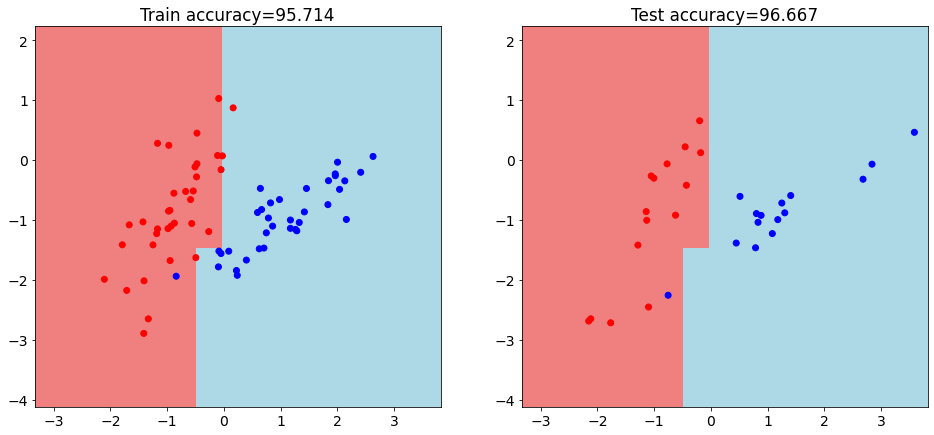

In [701]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, shading= 'nearest',cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.3f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, shading= 'nearest',cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.3f}')

Вывод: при использовании энтропии в качестве критерия разбиения, падает точность классификации.

# Задача 3

(*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.